## Water Extraction Forecasting

The data includes the date-time from 2013 to 2018 in a daily frequency. 

The complete feature list is as follows:

* Date: Day - Month - Year format
* DHIAv: Direct Horizontal Irradiance - Average
* DHIMax: Direct Horizontal Irradiance - Max 
* DNIAv: Direct Normal Irradiance - Average
* DNIMax: Direct Normal Irradiance - Max
* GHIAv: Global Horizontal Irradiance - Average
* GHIMax: Global Horizontal Irradiance - Max
* CDHIAv: Clearsky DHI - Average
* CDHIMax: Clearsky DHI - Max
* CDNIAv: Clearksy DNI - Average
* CDNIMax: Clearksy DNI - Max
* CGHIAv: Clearsky GHI - Average
* CGHIMax: Clearsky GHI - Max
* DPMin: Dew Point - Min
* DPAv: Dew Point - Average
* DPMax: Dew Point - Max
* WSMin: Wind Speed - Min
* WSAv: Wind Speed - Average
* WSMax: Wind Speed - Max
* RainMin: Rain - Min
* RainAv: Rain - Average
* RainMax: Rain - Max
* RHMin: Relative Humidity - Min
* RHAv: Relative Humidity - Average
* RHMax: Relative Humidity - Max
* Tmin: Temperature - Min
* TAv: Temperature - Average
* TMax: Temperature - Max
* PMin: Pressure - Min
* PAv: Pressure - Average
* PMax: Pressure - Max
* year: Year, goes from 2013 to 2018
* month: Month, goes from 1 to 12
* day: Day, goes from 1 to 31
* Weekday: Weekday (1: yes) 
* Weekend: Weekend (1: yes)
* Festive: Festive (free labor day) (1: yes)

Desired forecast feature:
* Q: Volumetric flowrate used during that day from the natural sources to provide the city with the demanded water 

Total data points: 2191
Total features: 37

Based on:
* https://colab.research.google.com/drive/1k3PLdczAJOIrIprfhjZ-IRXzNhFJ_OTN#scrollTo=pi0RNcp2oDCR
* https://www.curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

## Import libraries

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
from math import sqrt



%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

## Pre-processing

In [20]:
# import dataset 

df = pd.read_csv("C:/Users/3PX00LA_RS4/Documents/ATOS challenge/Damanda Diaria/Models/DataFinalLSTMCleaned.csv", parse_dates=['date'], index_col='date')

# summarize dataset pre-feature engineering
df.head()

,DHIAv,DHIMax,DNIAv,DNIMax,GHIAv,GHIMax,CDHIAv,CDHIMax,CDNIAv,CDNIMax,...,TMin,TAv,TMax,PMin,PAv,PMax,Weekday,Weekend,Festive,Q
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,60.041667,232,9.083333,145,64.625000,271,37.041667,118,291.458333,846,...,10.0,14.500000,18.0,950,952.083333,960,1,0,1,10782.8398
2013-01-02,42.875000,165,0.041667,1,42.916667,166,41.125000,129,274.583333,818,...,8.0,9.291667,12.0,950,955.416667,960,1,0,0,8289.3878
2013-01-03,46.000000,192,125.375000,792,106.833333,666,49.125000,156,263.291667,798,...,5.0,7.166667,10.0,960,960.000000,960,1,0,0,9153.6818
2013-01-04,44.375000,166,145.791667,823,110.583333,669,44.625000,135,271.791667,830,...,5.0,8.125000,15.0,960,960.000000,960,1,0,0,8894.7788
2013-01-05,64.875000,291,180.791667,896,153.500000,684,36.375000,117,300.791667,901,...,7.0,11.791667,21.0,960,960.000000,960,0,1,0,9691.8726


In [21]:
# Feature engineering to set extract data from date

df['year'] = df.index.year
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# summarize dataset post-feature engineering
df.head()

,DHIAv,DHIMax,DNIAv,DNIMax,GHIAv,GHIMax,CDHIAv,CDHIMax,CDNIAv,CDNIMax,...,PAv,PMax,Weekday,Weekend,Festive,Q,year,day_of_month,day_of_week,month
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,60.041667,232,9.083333,145,64.625000,271,37.041667,118,291.458333,846,...,952.083333,960,1,0,1,10782.8398,2013,1,1,1
2013-01-02,42.875000,165,0.041667,1,42.916667,166,41.125000,129,274.583333,818,...,955.416667,960,1,0,0,8289.3878,2013,2,2,1
2013-01-03,46.000000,192,125.375000,792,106.833333,666,49.125000,156,263.291667,798,...,960.000000,960,1,0,0,9153.6818,2013,3,3,1
2013-01-04,44.375000,166,145.791667,823,110.583333,669,44.625000,135,271.791667,830,...,960.000000,960,1,0,0,8894.7788,2013,4,4,1
2013-01-05,64.875000,291,180.791667,896,153.500000,684,36.375000,117,300.791667,901,...,960.000000,960,0,1,0,9691.8726,2013,5,5,1


## Visualization

### Volumetric Flowrate vs Time

The graph below shows the behavior of our desired feature to predict (Q) versus time. It is clear that it shows a seasonality trend. As each year has a cycle, and the trend seems upwards.

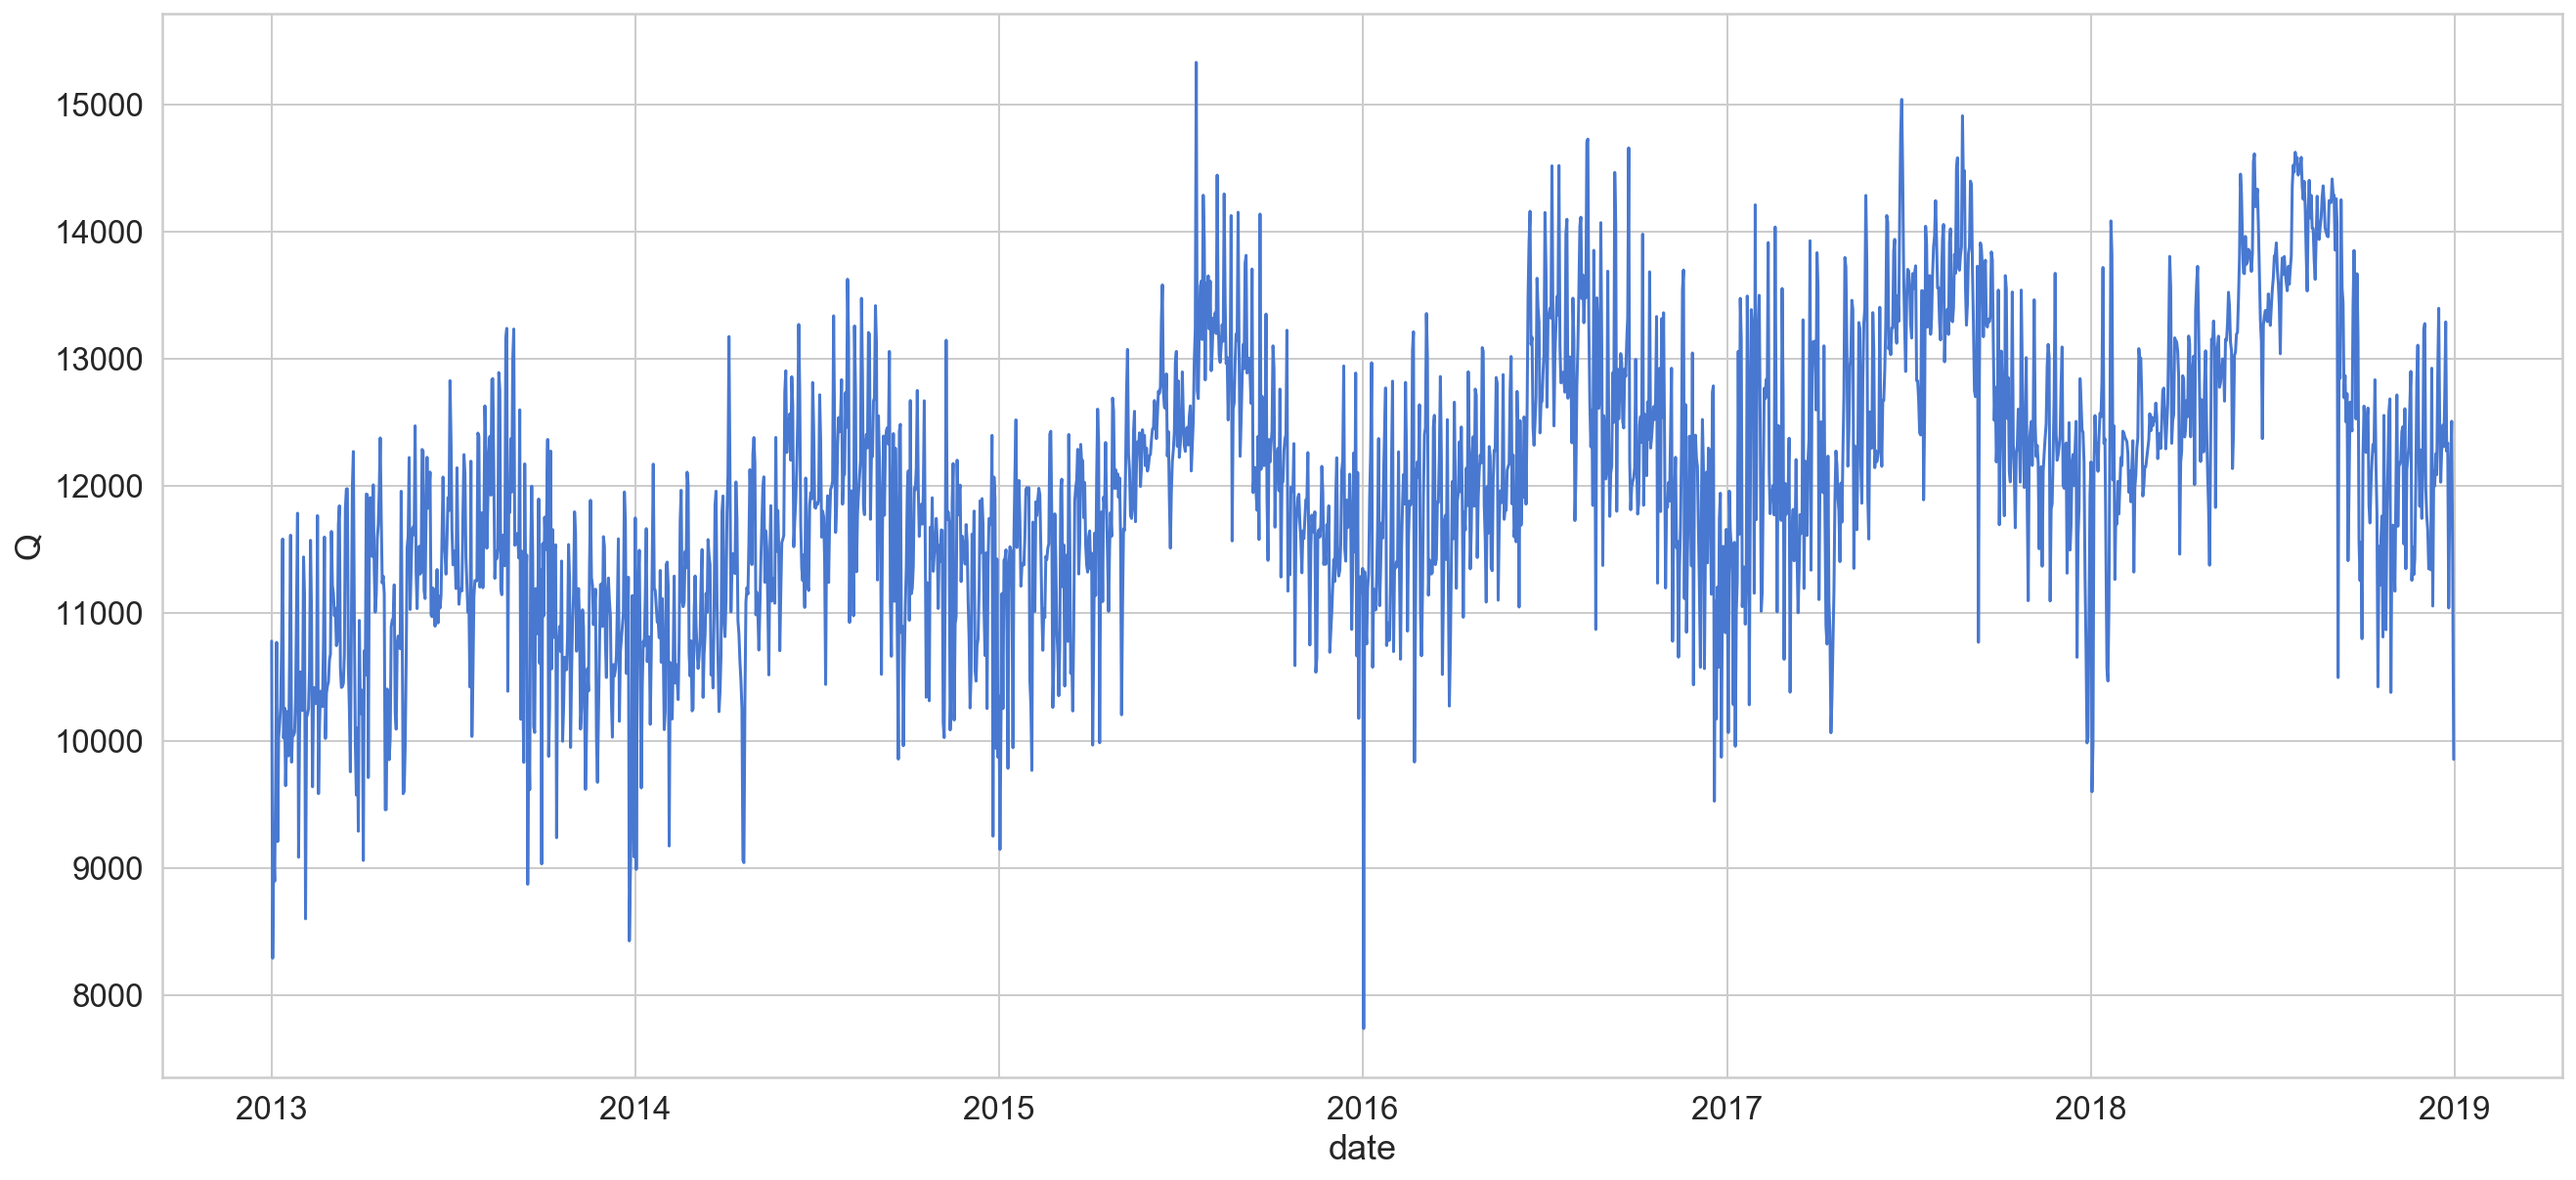

In [22]:
sns.lineplot(x=df.index, y="Q", data=df);

### Volumetric Flowrate vs Time without noise 

This is made for a better visualization

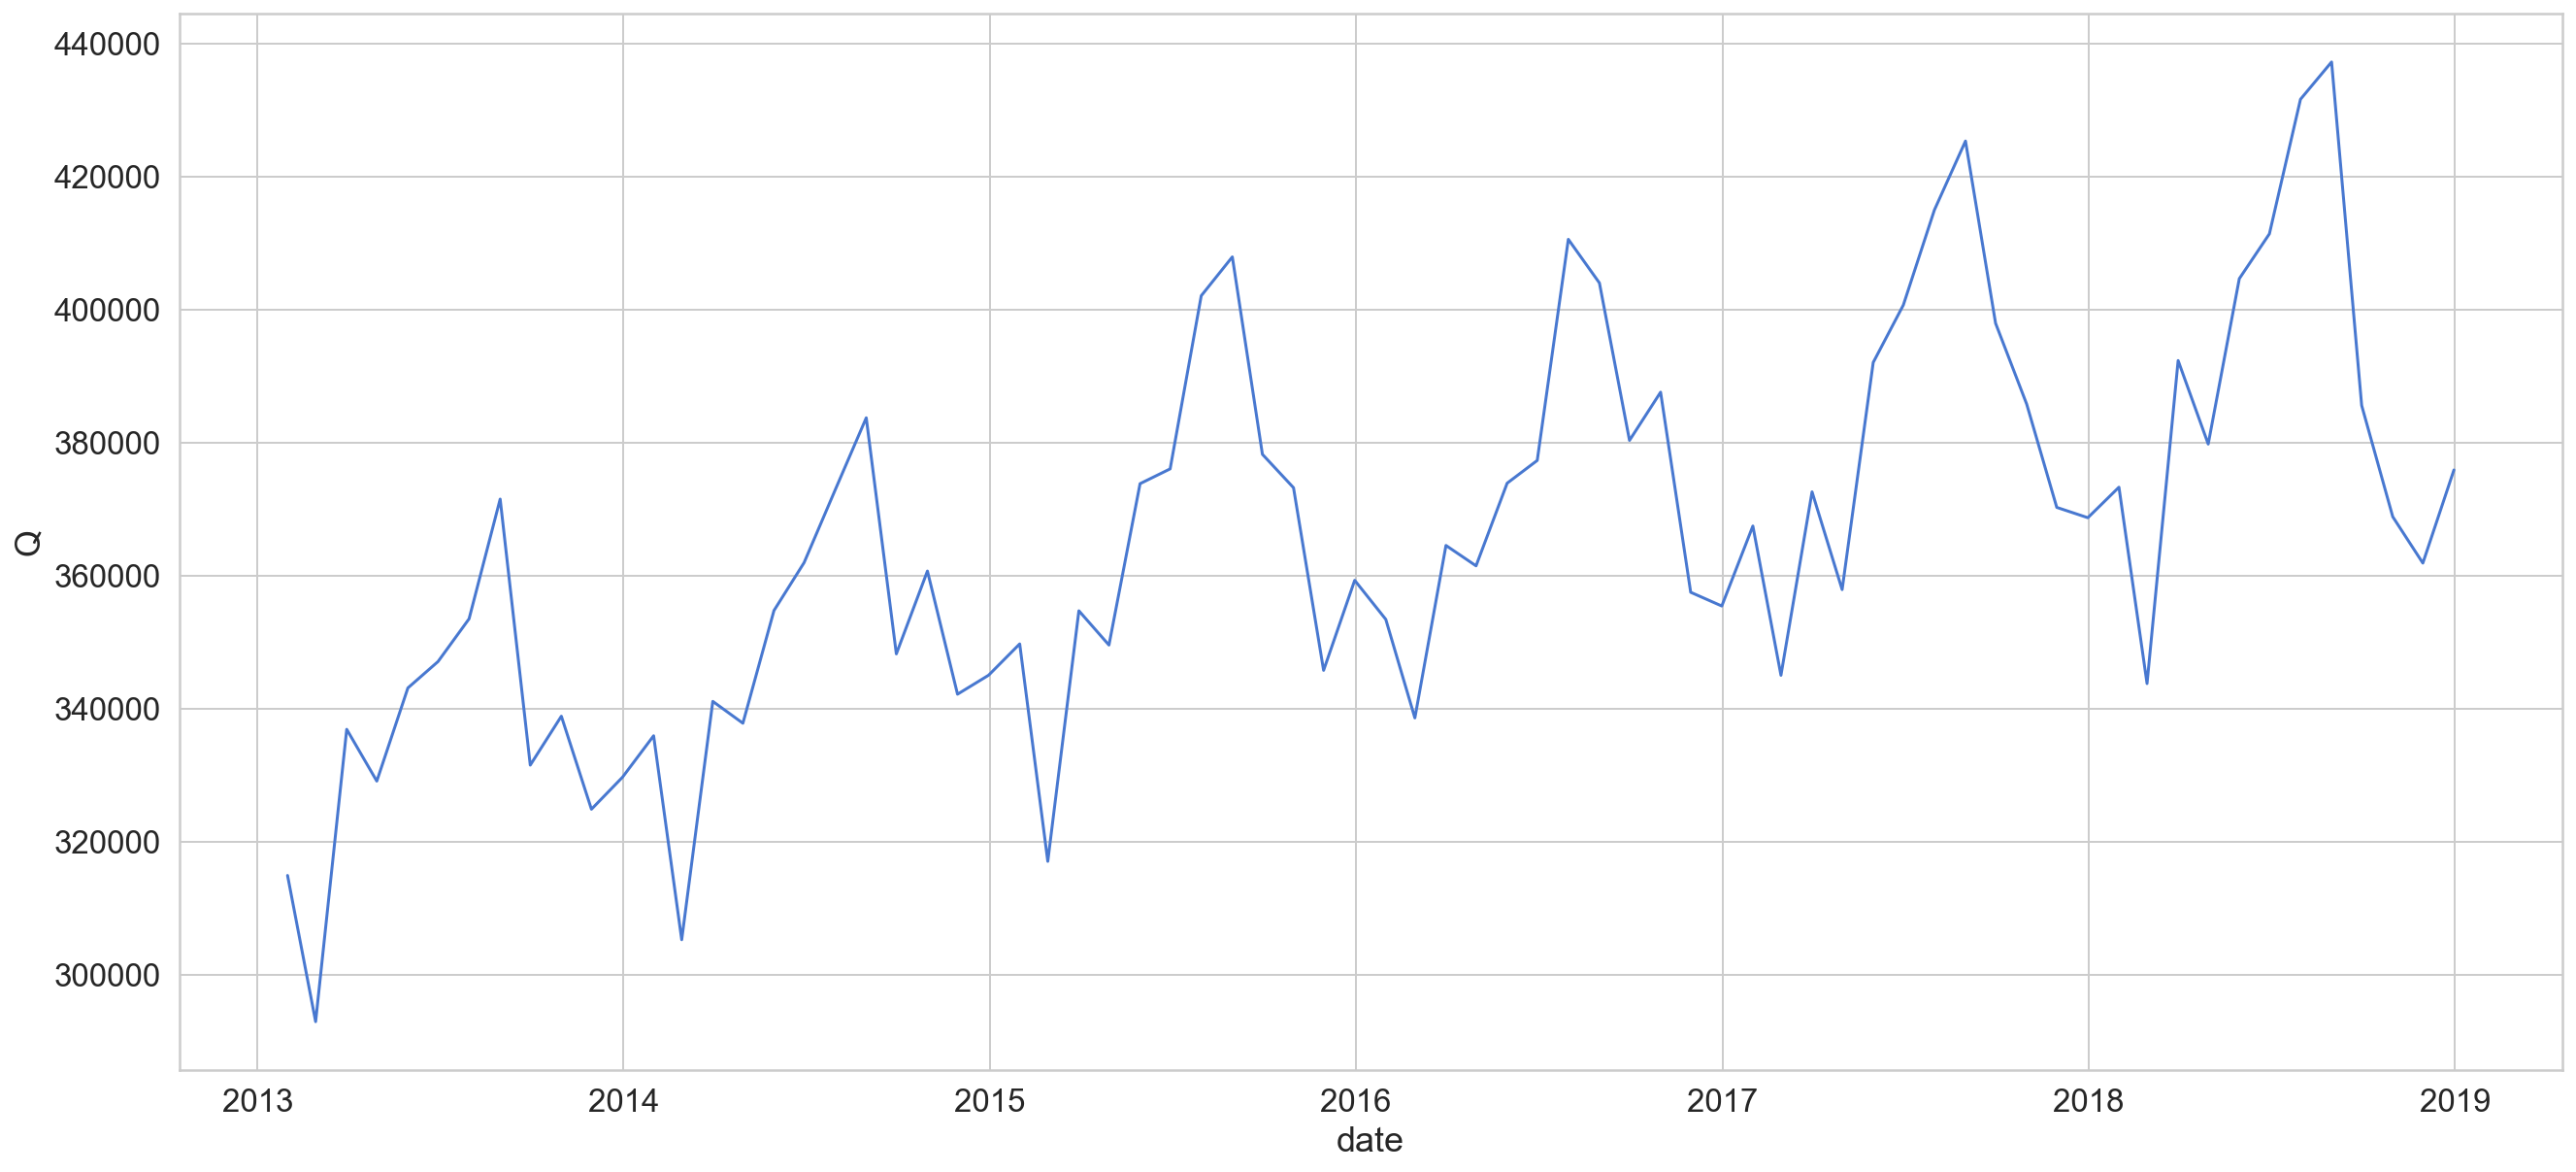

In [23]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="Q", data=df_by_month);

### General Monthly Trends

* Graph 1: Shows the general trend of water extraction for each month. August is the month in which more water is demanded, all years.
* Graph 2: Shows that festive do not leads to a higher demand in water extraction
* Graph 3: Shows that weekends tend to demand much more water demand

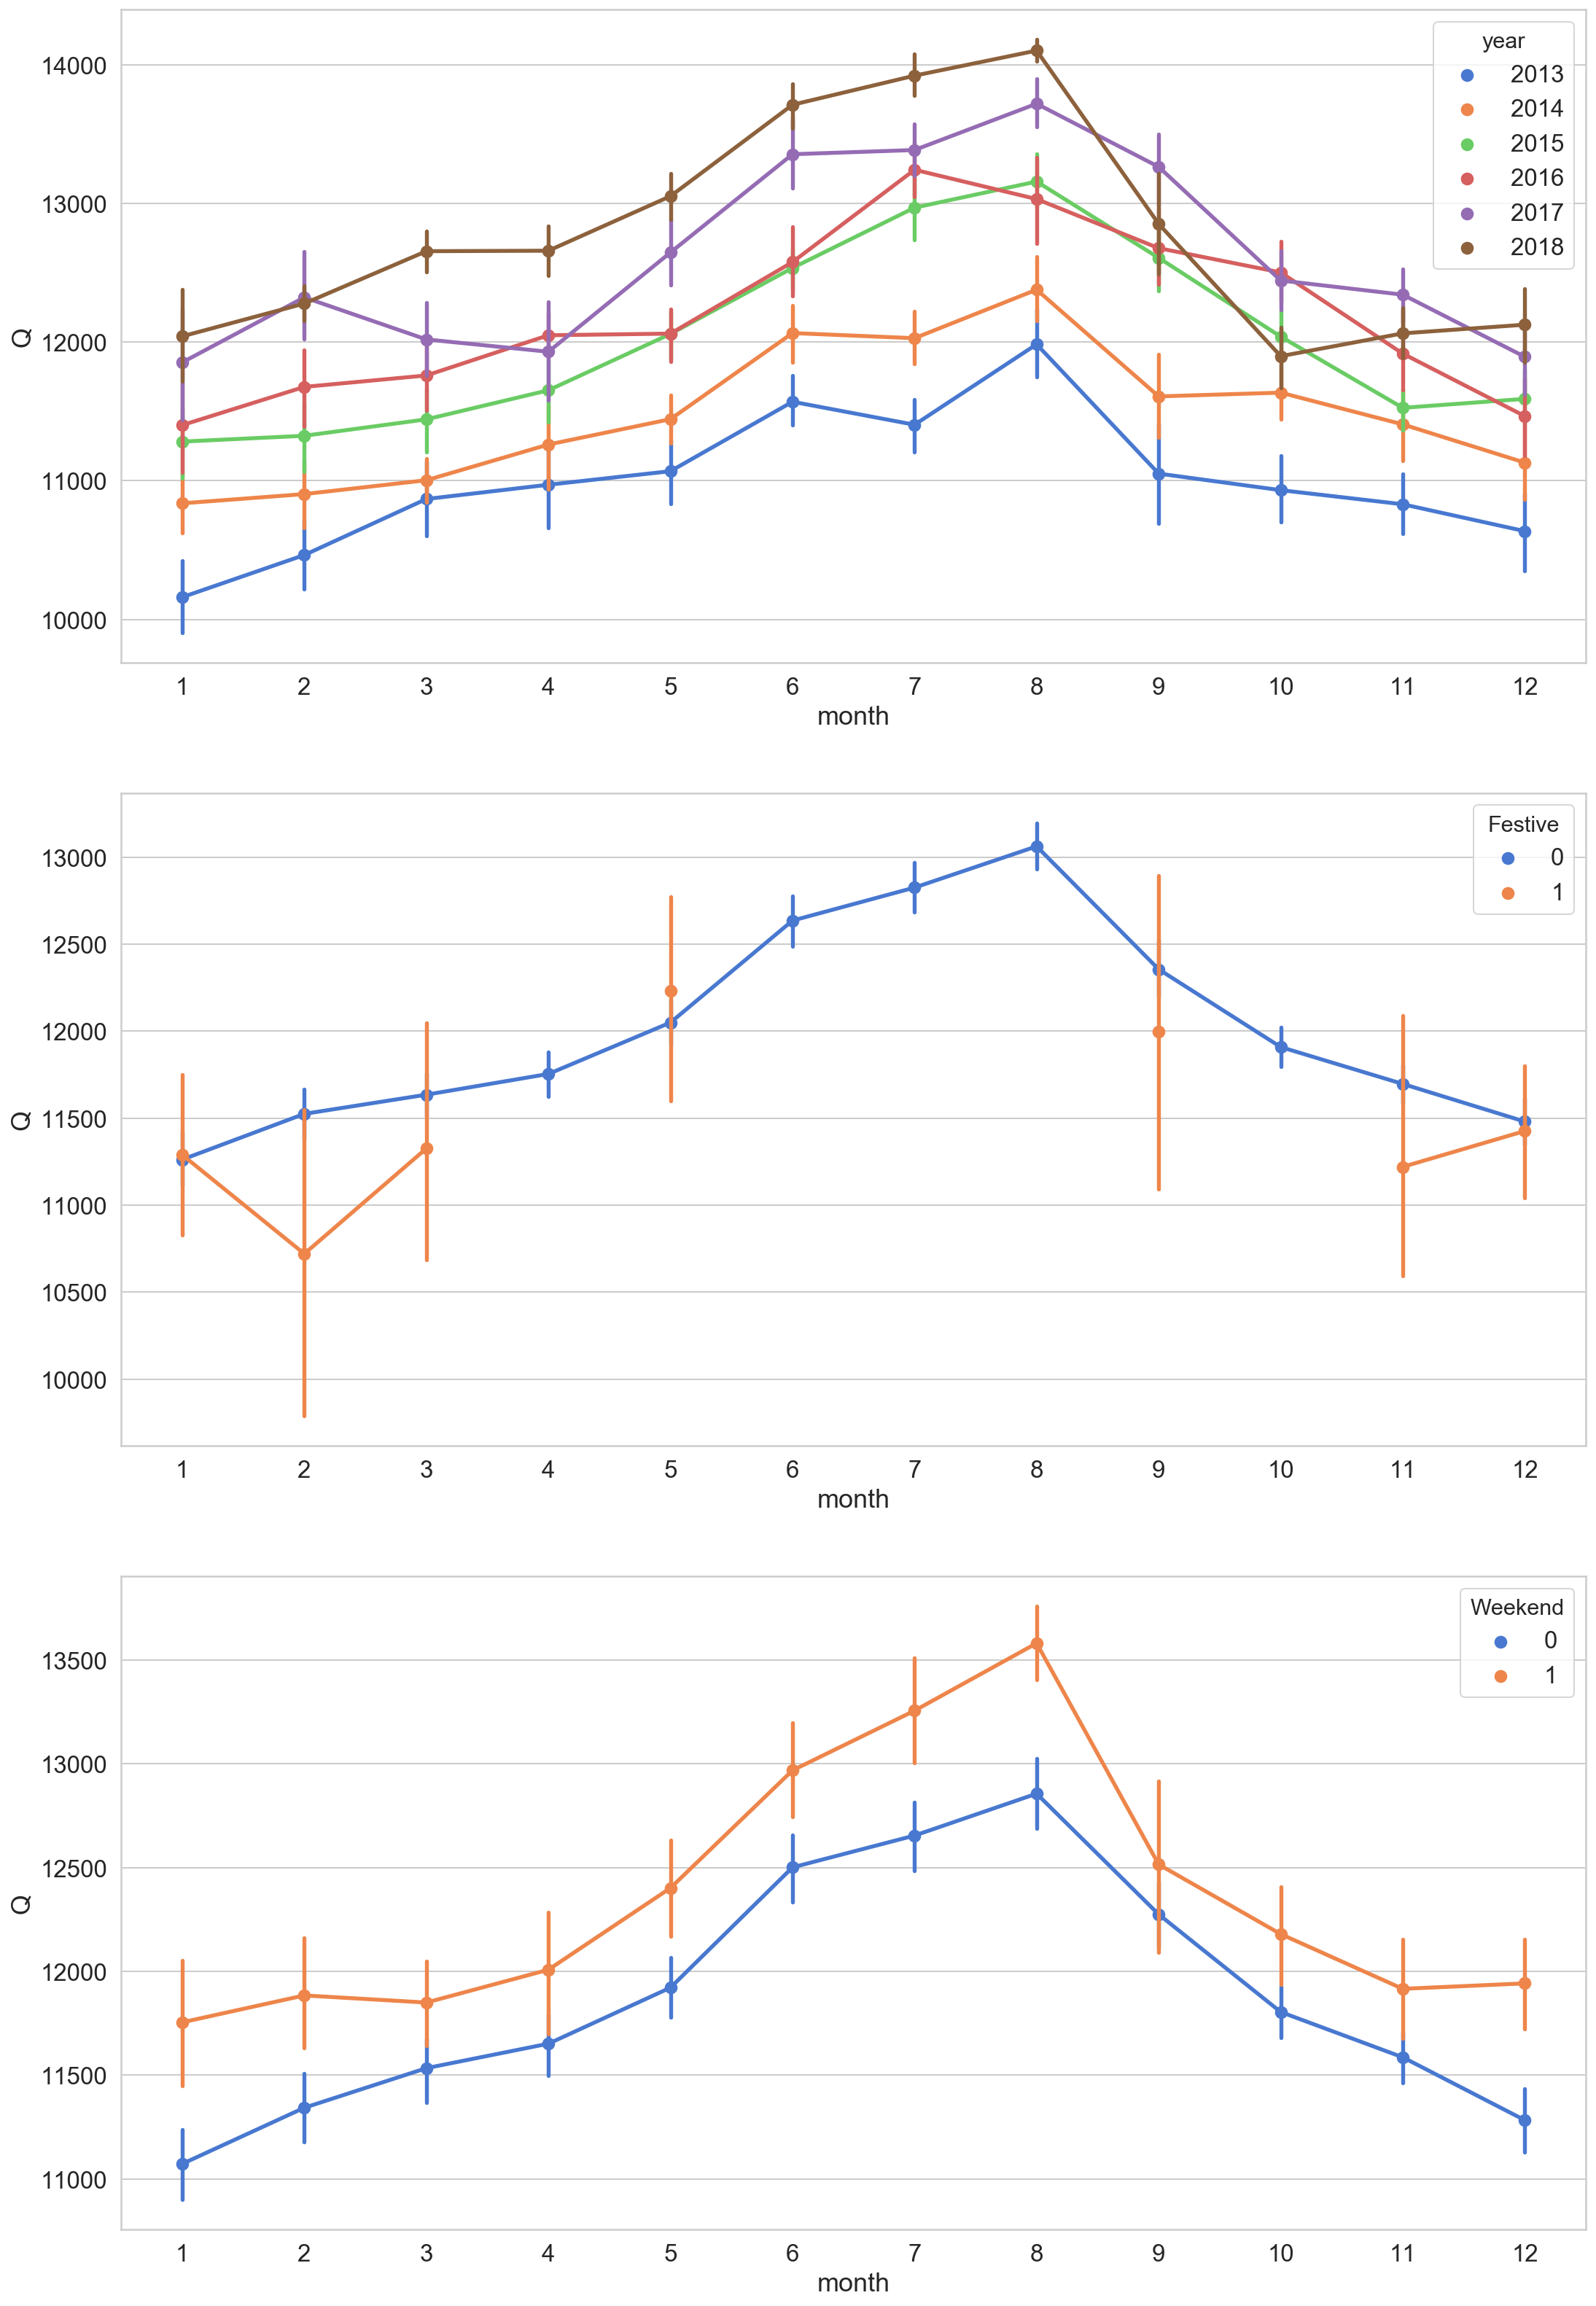

In [24]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='month', y='Q', hue= 'year', ax=ax1)
sns.pointplot(data=df, x='month', y='Q', hue='Festive', ax=ax2)
sns.pointplot(data=df, x='month', y='Q', hue='Weekend', ax=ax3)
#sns.pointplot(data=df, x='hour', y='Q', hue='season', ax=ax4);

### General Daily Trends

* Graph 1: Shows that Saturdays are the days that demand more water extraction.
* Graph 2: Shows that the previous trends has not changed throughout the years.

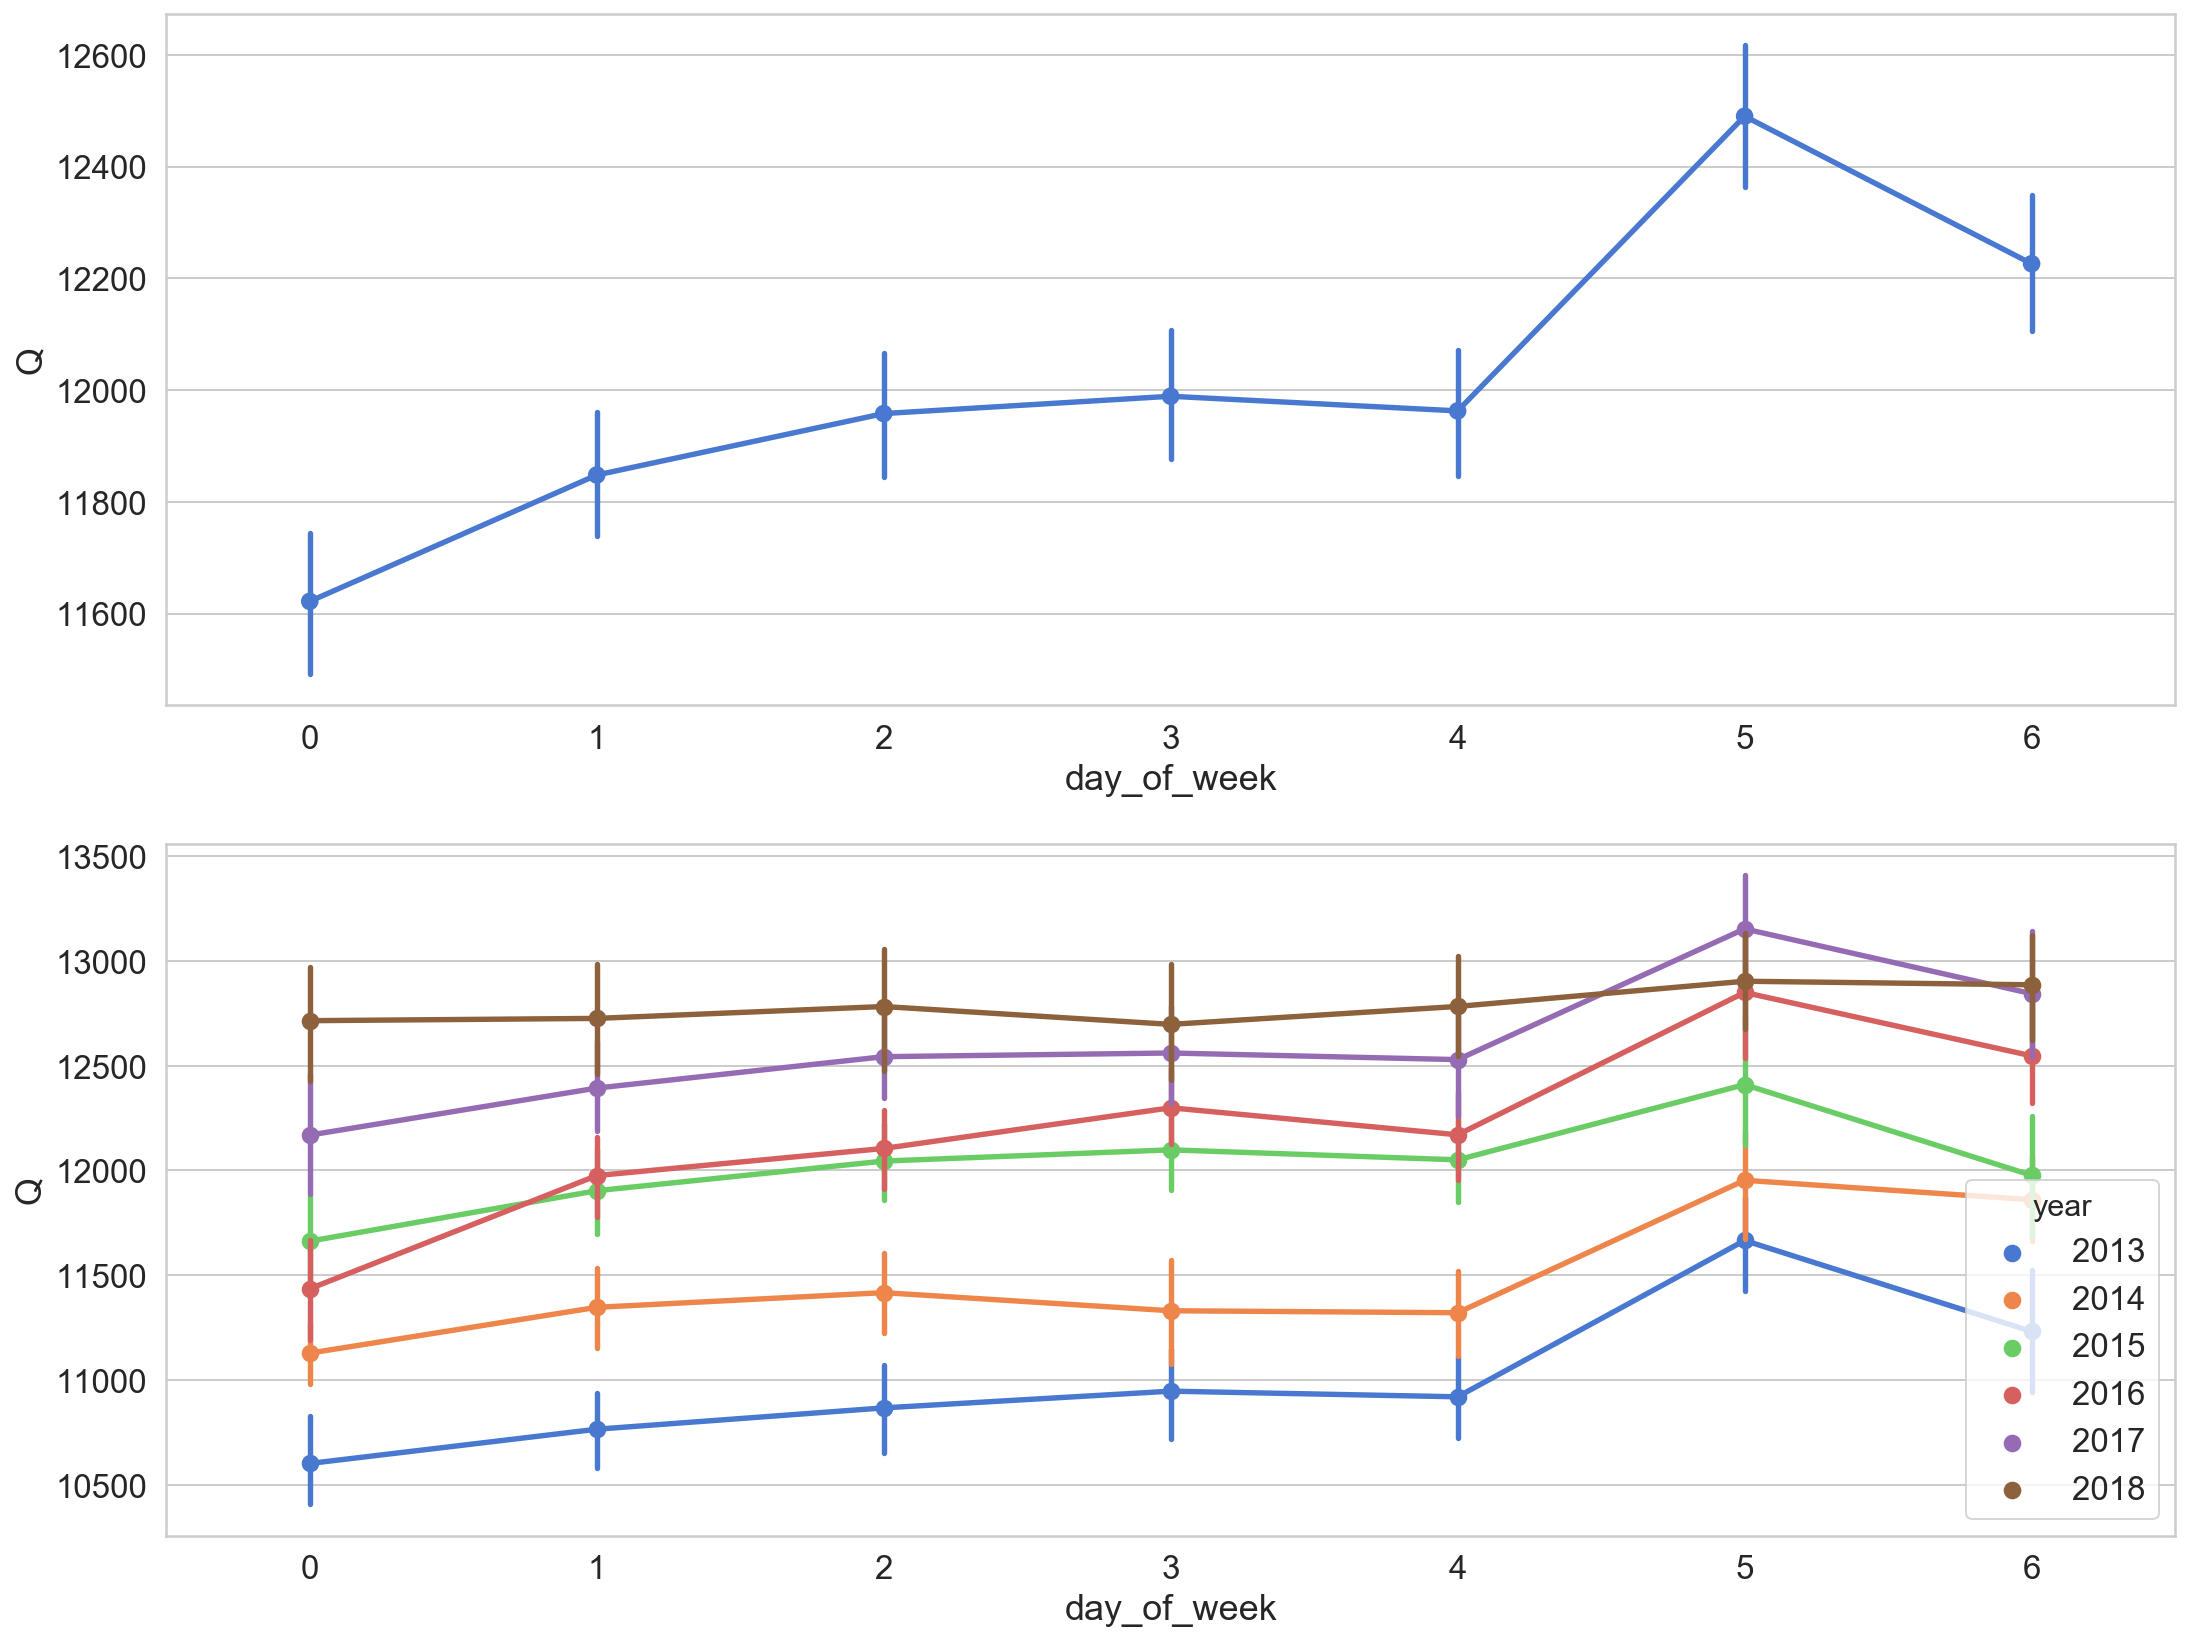

In [25]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='Q', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='Q', hue='year', ax=ax2);

### Split into train and test sets

In [26]:
# Train 80% of data, and 20% of test data

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

1752 439


### Normalization of data

In [27]:
# establish desired feature for prediction
desired_column = ["Q"]

# take all column names into a list array
all_columns_names = df.columns.values.tolist()

# from all the column names, eliminate the desired feature for prediction
sublist = [x for x in all_columns_names if x not in desired_column]

# move list with all features but Q into a new array
f_columns = sublist

# normalization package to be used 

f_transformer = RobustScaler()
Q_transformer = RobustScaler()

# the fitting should only be in the train data, bc test data should not have info during the training
# scalling test data is a COMMON MISTAKE
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
Q_transformer = Q_transformer.fit(train[['Q']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Q'] = Q_transformer.transform(train[['Q']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Q'] = Q_transformer.transform(test[['Q']])

# NOTE: THIS WILL RESULT IN A WARNING I DO NOT KNOW HOW TO FIX IT YET

C:\Users\3PX00LA_RS4\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\3PX00LA_RS4\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\3PX00LA_RS4\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

### Function to prepare sequences

In [28]:
# Takes all values from i position + time steps, then takes "y" values
# Creates series that uses history from the time that is specified, then predicts the current value

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [29]:
# This specifies how many days into the past the model will take data from
time_steps = 14

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Q, time_steps)
X_test, y_test = create_dataset(test, test.Q, time_steps)

print(X_train.shape, y_train.shape)

(1738, 14, 38) (1738,)


### Model definition

In [30]:
# design network
# 128 neurons
# Dropout layer penalizes values 
# Dense is output layer (single numerical), always 1

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Training 

In [31]:
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=True, 
    validation_split=0.2,
    shuffle=False
)

Train on 1390 samples, validate on 348 samples
Epoch 1/50
1390/1390 [==============================] - 17s 12ms/sample - loss: 0.2423 - val_loss: 0.3569
Epoch 2/50
1390/1390 [==============================] - 12s 9ms/sample - loss: 0.1767 - val_loss: 0.3253
Epoch 3/50
1390/1390 [==============================] - 14s 10ms/sample - loss: 0.1570 - val_loss: 0.3695
Epoch 4/50
1390/1390 [==============================] - 13s 9ms/sample - loss: 0.1370 - val_loss: 0.3376
Epoch 5/50
1390/1390 [==============================] - 12s 9ms/sample - loss: 0.1255 - val_loss: 0.3657
Epoch 6/50
1390/1390 [==============================] - 13s 9ms/sample - loss: 0.1135 - val_loss: 0.3256
Epoch 7/50
1390/1390 [==============================] - 13s 9ms/sample - loss: 0.1002 - val_loss: 0.3313
Epoch 8/50
1390/1390 [==============================] - 12s 9ms/sample - loss: 0.0872 - val_loss: 0.3216
Epoch 9/50
1390/1390 [==============================] - 12s 9ms/sample - loss: 0.0824 - val_loss: 0.3230
Epoch 

### Loss vs epochs

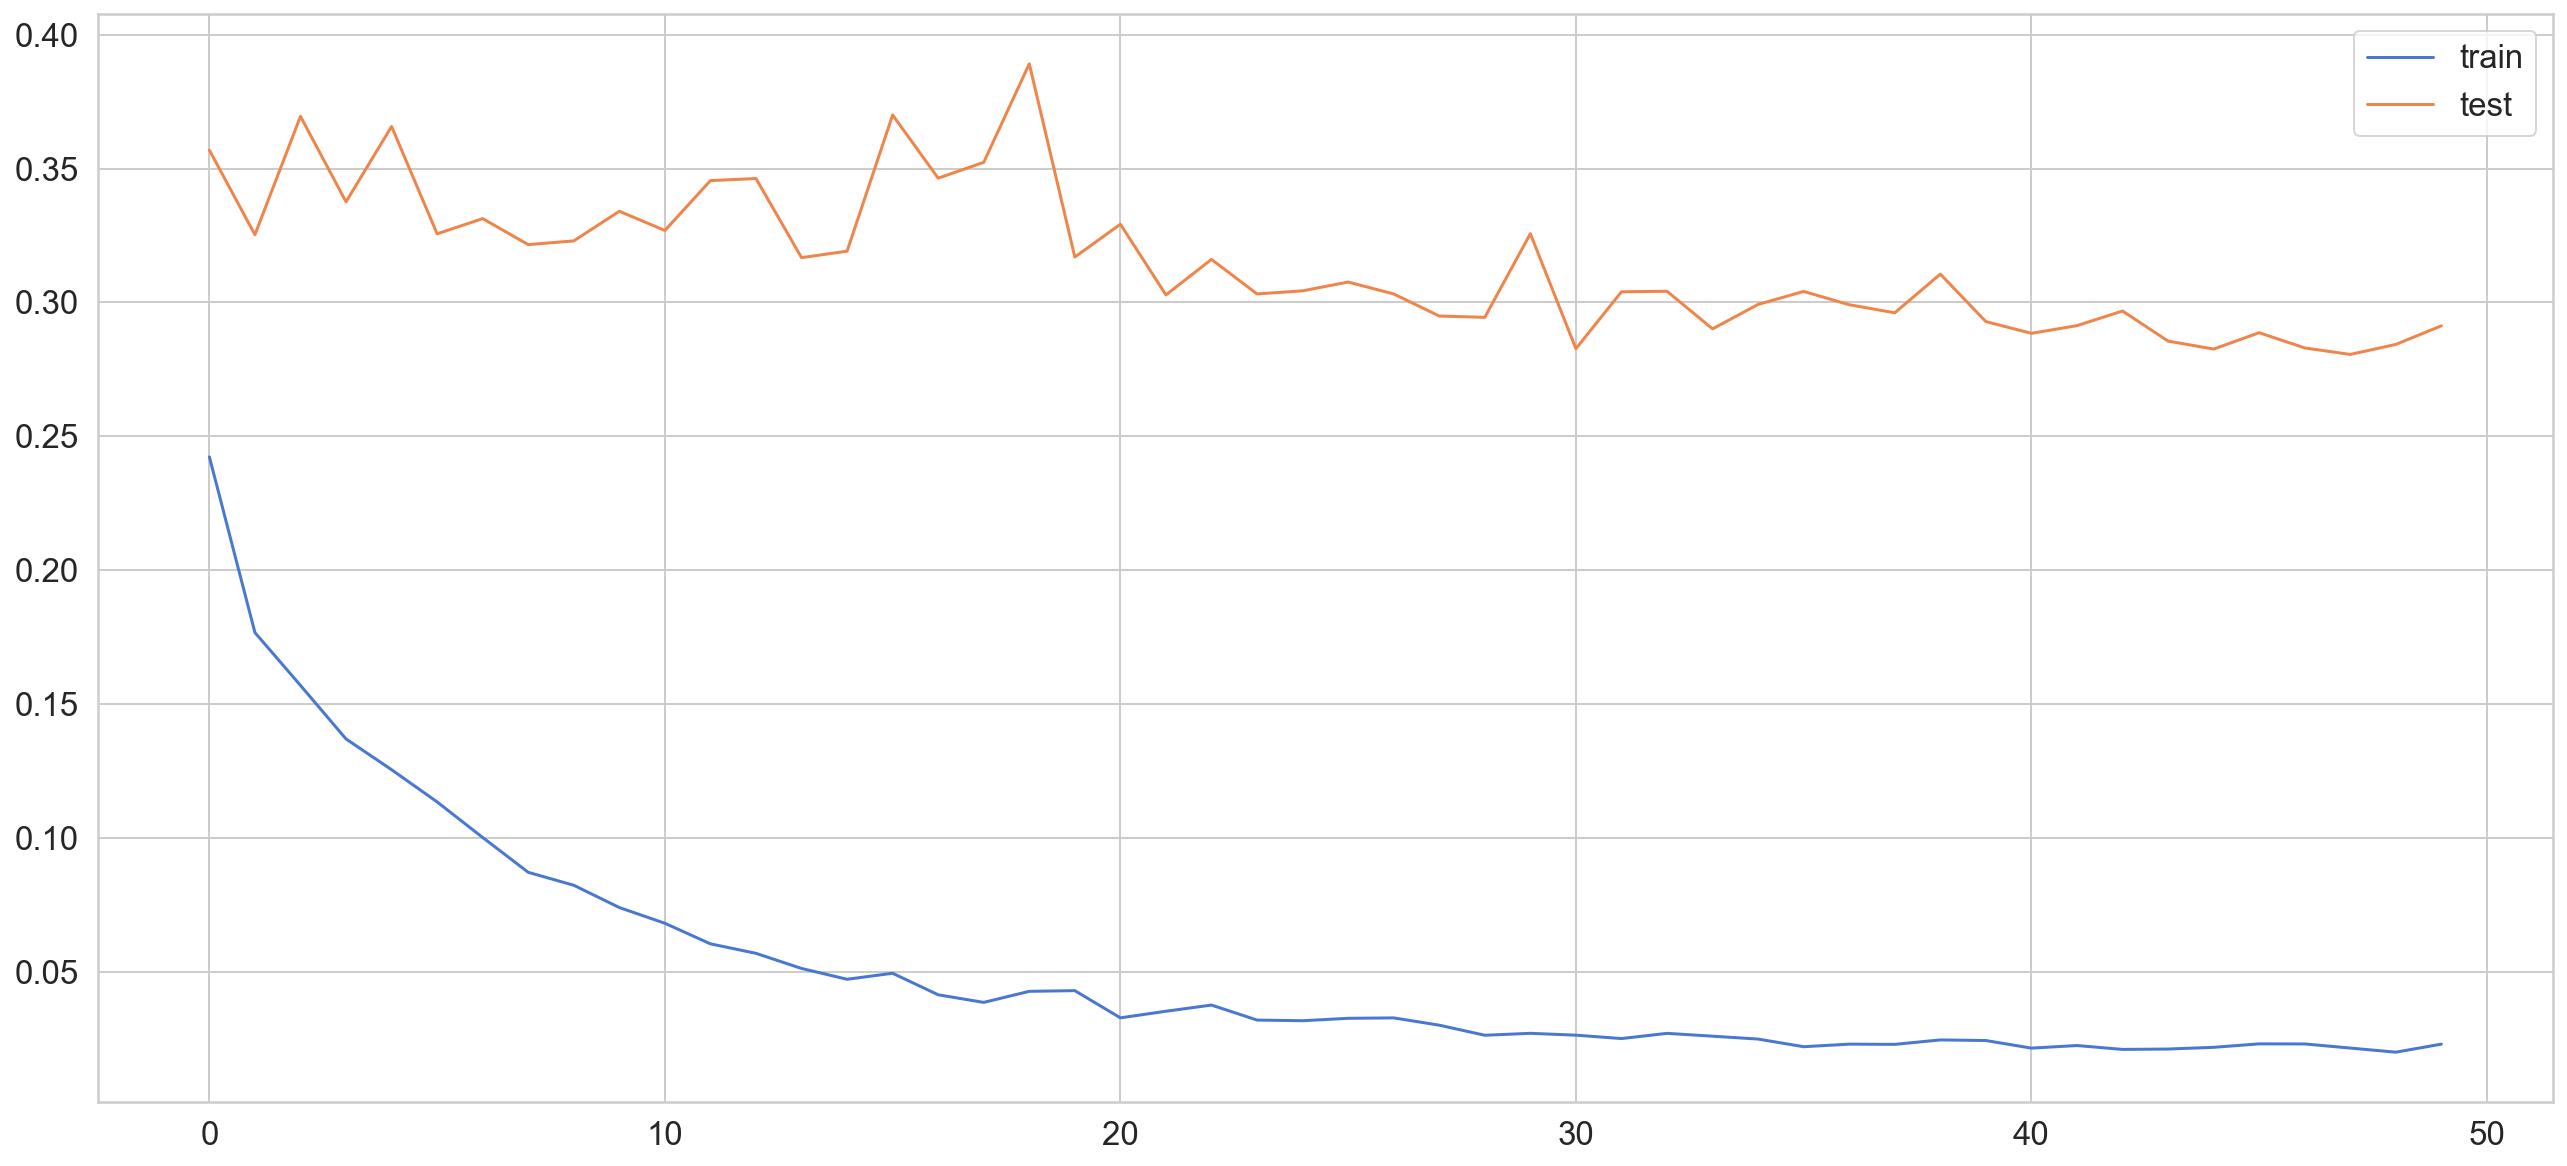

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Prediction

In [33]:
y_pred = model.predict(X_test)

### Reverse scale

In [34]:
y_train_inv = Q_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = Q_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = Q_transformer.inverse_transform(y_pred)

### Prediction vs Actual Graph

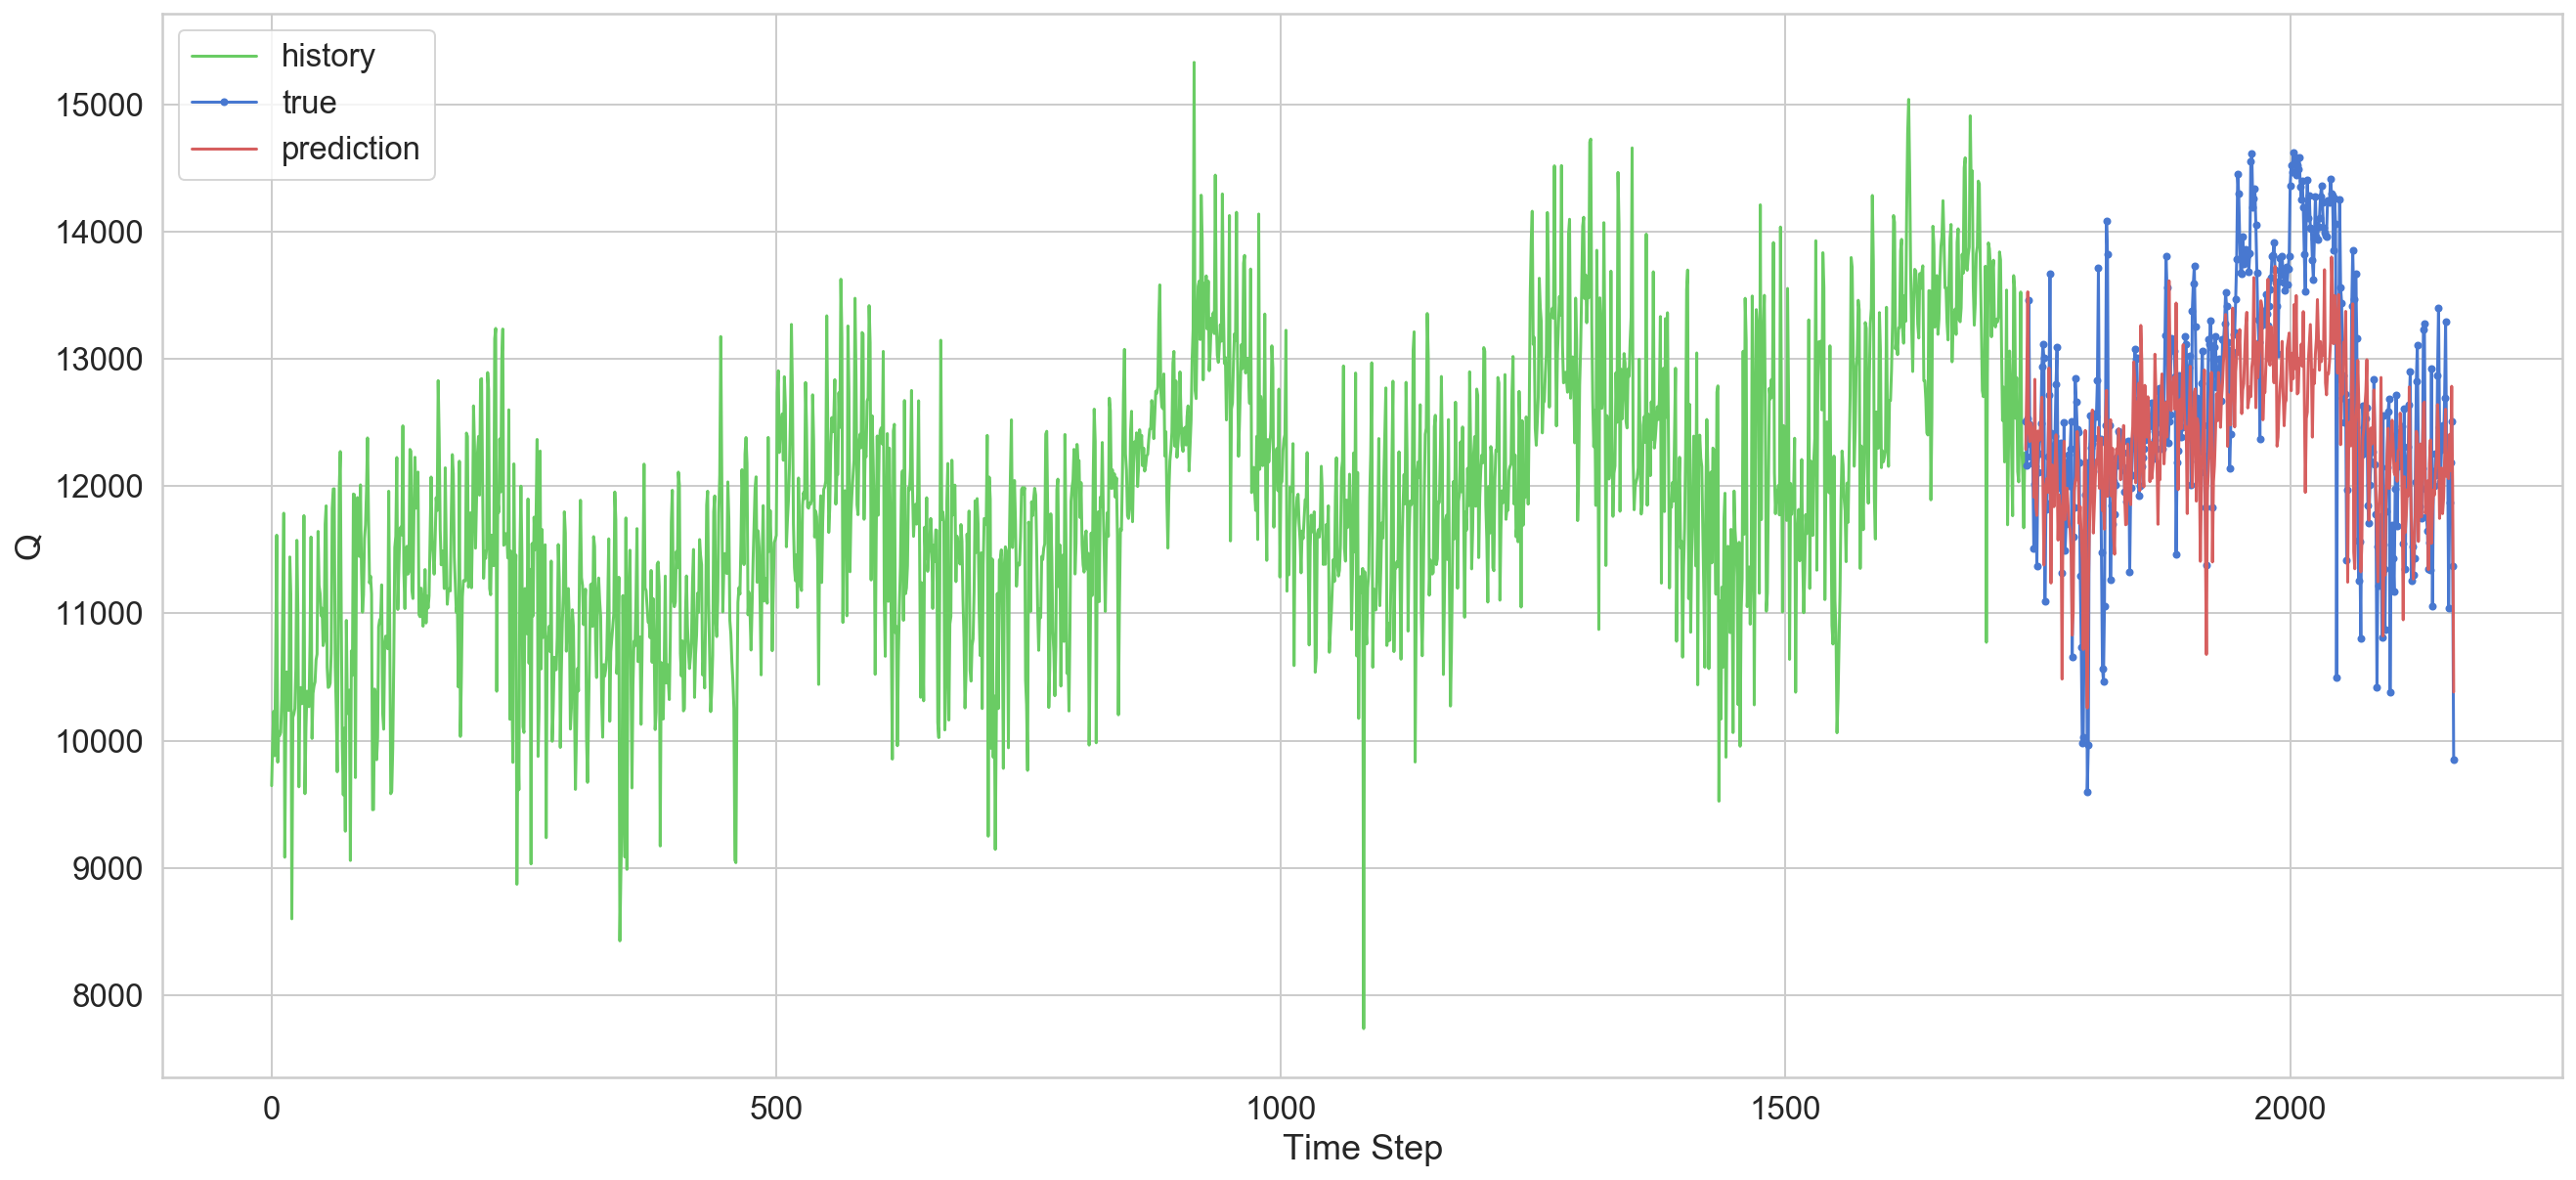

In [35]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Q')
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Predicion vs Actual Graph

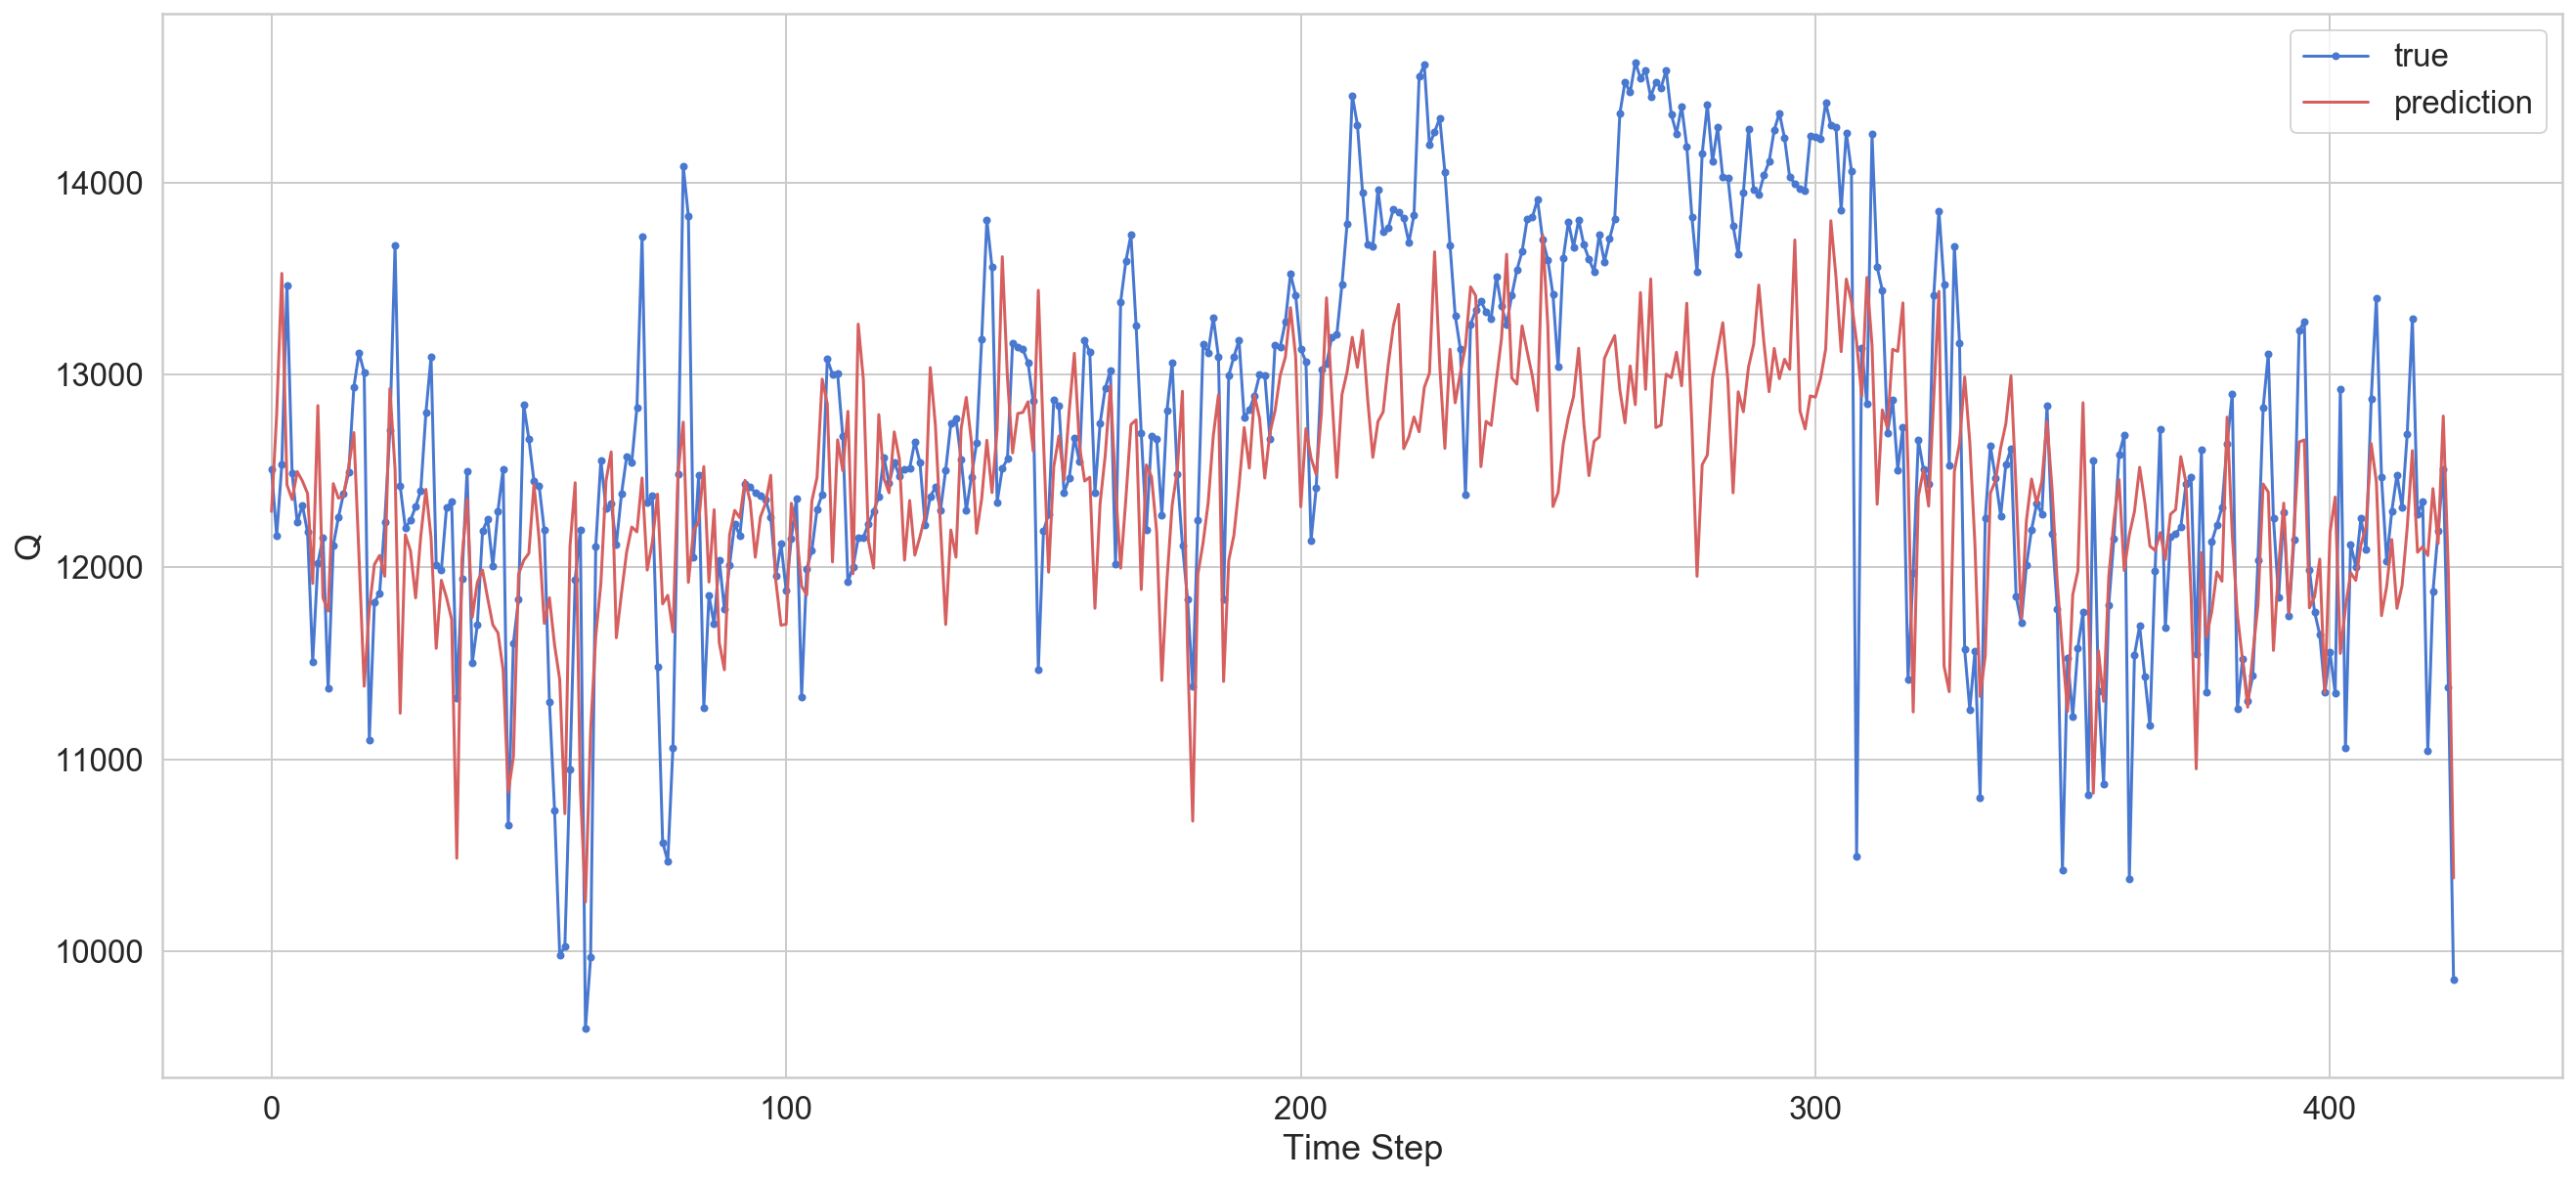

In [36]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Q')
plt.xlabel('Time Step')
plt.legend()
plt.show();